<a href="https://colab.research.google.com/github/SunkaraboinaPraveenKumar/Machine_Learning_Projects/blob/main/DeepLearning_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Generative Adversarial Network for an MNIST Handwritten Digits From Scratch in Keras

In [1]:
from tensorflow.keras.datasets.mnist import load_data

In [2]:
(trainX, trainy), (testX, testy)=load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [3]:
print('Train', trainX.shape, trainy.shape)

Train (60000, 28, 28) (60000,)


In [4]:
print('Test',testX.shape,testy.shape)

Test (10000, 28, 28) (10000,)


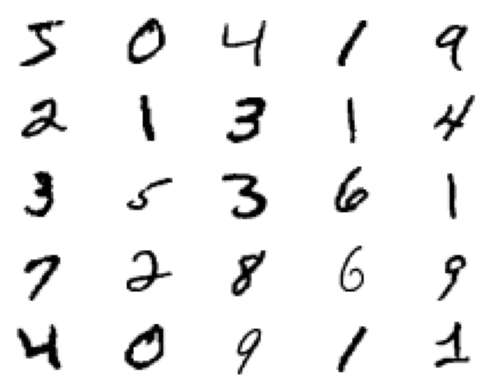

In [5]:
from tensorflow.keras.datasets.mnist import load_data
from matplotlib import pyplot
for i in range(25):
  pyplot.subplot(5,5,i+1)
  pyplot.axis('off')
  pyplot.imshow(trainX[i], cmap='gray_r')

pyplot.show()

In [6]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf
from IPython import display

In [7]:
(train_images, train_labels),(_,_)=tf.keras.datasets.mnist.load_data()

In [8]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [9]:
BUFFER_SIZE=60000
BATCH_SIZE=256

In [10]:
train_dataset=tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

The Generator
The generator uses tf.keras.layers.Conv2DTranspose (upsampling) layers to produce an image from a random noise.

In [11]:
# input 7*7*256 (low resolution version of the output image)
# outputs a single 28×28 grayscale image
# this generator takes a vector of size 100 and first reshape that into (7, 7, 128) vector then applied transpose
# convolution in combination with batch normalization.

In [12]:
def make_generator_model():
  model=tf.keras.Sequential()
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  model.add(layers.Reshape((7,7,256)))
  assert model.output_shape==(None,7,7,256)
  model.add(layers.Conv2DTranspose(128,(5,5),strides=(1,1),padding='same', use_bias=False))
  assert model.output_shape==(None,7,7,128)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  #upsample to 14X14
  model.add(layers.Conv2DTranspose(64,(5,5),strides=(2,2),padding='same', use_bias=False))
  assert model.output_shape==(None,14,14,64)
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  #upsample to 28x28
  model.add(layers.Conv2DTranspose(1,(5,5), strides=(2,2),padding='same', use_bias=False, activation='tanh'))
  assert model.output_shape==(None,28,28,1)

  return model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


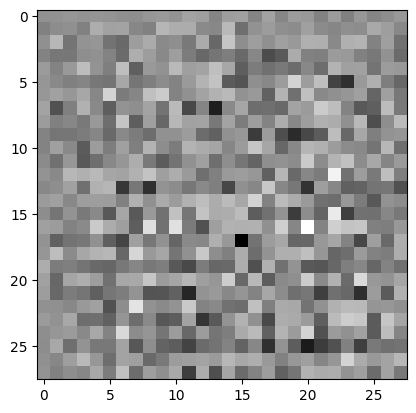

In [13]:
generator=make_generator_model()
noise = tf.random.normal([1,100])
generated_image=generator(noise, training=False)

plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [14]:
# Input to discriminator = 28*28*1   grayscale image
# Output  binary prediction (image is real (class=1) or fake (class=0))
# no pooling layers
# single node in the output layer with the sigmoid activation function to predict whether the input sample is real or fake.
# Downsampling from 28×28 to 14×14, then to 7×7, before the model makes an output prediction

In [15]:
def make_discriminator_model():
  model=tf.keras.Sequential()

  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten()) # for classification
  model.add(layers.Dense(1, activation='sigmoid'))

  return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [16]:
discriminator=make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


tf.Tensor([[0.49965227]], shape=(1, 1), dtype=float32)


Define Loss and Optimizers

In [17]:
cross_entropy=tf.keras.losses.BinaryCrossentropy(from_logits=True)

Discriminator loss
This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [18]:
def discriminator_loss(real_output, fake_output):
  real_loss=cross_entropy(tf.ones_like(real_output),real_output)
  fake_loss=cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss=real_loss+fake_loss
  return total_loss

Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, compare the discriminators decisions on the generated images to an array of 1s.

In [19]:
def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output),fake_output)

In [20]:
generator_optimizer=tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer=tf.keras.optimizers.Adam(1e-4)

In [21]:
checkpoint_dir="./training_checkpoints"
checkpoint_prefix=os.path.join(checkpoint_dir, "ckpt")
checkpoint=tf.train.Checkpoint(
    generator_optimizer=generator_optimizer,
    discriminator_optimizer=discriminator_optimizer,
    generator=generator,
    discriminator=discriminator
)

In [22]:
EPOCHS=50
noise_dim=100
num_examples_to_generate=16

seed=tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [23]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images=generator(noise,training=True)

    real_output=discriminator(images, training=True)
    fake_output=discriminator(generated_images, training=True)

    gen_loss=generator_loss(fake_output)
    disc_loss=discriminator_loss(real_output, fake_output)

    gradients_of_generator=gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator=disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [24]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [25]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as you go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

Call the train() method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

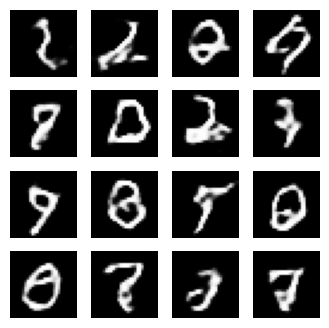

In [26]:
train(train_dataset, EPOCHS)

In [27]:

checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [28]:
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

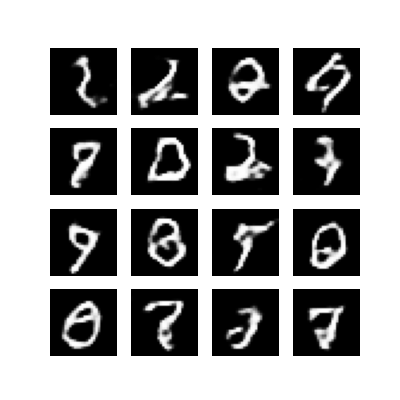

In [29]:
display_image(EPOCHS)

In [30]:
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-1ua6vdym
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /tmp/pip-req-build-1ua6vdym
  Resolved https://github.com/tensorflow/docs to commit 9d688b86c4564044a8de72783c1eb941a4e1c7b6
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-docs: filename=tensorflow_docs-2025.2.19.33219-py3-none-any.whl size=182608 sha256=0aed6981f22df792bd25af1e4b2a507d3134da013c559ed1838035b9c4d8d8f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-g41ilyzz/wheels/34/53/89/3db54cf97ce0f0261aaab3fdc12a847ea0879d34edf373e2c5
Successfully built tensorflow-docs


In [32]:
# the latent space is just where you pick the noise from(to give to the generator)
# The generator model in the GAN architecture takes a point from the latent space as input and generates a new image.

# The latent space is a 100-dimensional space with random points. points in the latent space can be constructed (e.g. all 0s, all 0.5s, or all 1s)
# New images are generated using random points in the latent space.
# Points in the latent space used as input or a query to generate a specific image.